# Introduction

Задача: Это таблица с заявками по подтвержденным заказам банковских карт. \
Нам оплачивают только заявки в которых карта выдана и есть POS транзакция.

Задача: 
- рассказать, как нам максимизировать выручку
- и какие данные мы знаем о платящих пользователях,
- какая воронка из заявки в выдачу карты,
- есть ли корреляция между возрастом/регионом/полом в выдачу карты
- и есть ли скрытые закономерности.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

## Data preprocessing

In [2]:
data = pd.read_csv('test_data.csv', parse_dates=['ДАТА_РОЖДЕНИЯ'])
data

,ДАТА_ЛИДА,ВРЕМЯ_ЛИДА,ПРОДУКТ,ТАРИФ,РЕГИОН,ПОЛ,ДАТА_РОЖДЕНИЯ,ЛИД,СОГЛАСИЕ_КЛИЕНТА,ЭМИССИЯ,ВЫДАЧА,POS_ТРАНЗАКЦИЯ,ДОСТАВКА,ДАТА_ЭМИССИИ,ДАТА_ВЫДАЧИ,ДАТА_POS_ТРАНЗАКЦИИ,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,30.12.2020,23:23:34,opencard Нет,NaN,Оренбургская область,Ж,NaT,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,checkscan
1,30.12.2020,23:00:05,lukoil Оптимальный,NaN,Ставропольский край,Ж,NaT,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,checkscan
2,31.12.2020,00:34:36,opencard Нет,NaN,Москва,Ж,NaT,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,checkscan
3,01.01.2021,13:58:50,opencard Нет,Opencard,Томская область,М,1963-09-07,1.0,1.0,1.0,1.0,1.0,0.0,01.01.2021,15.01.2021,15.01.2021,NaN,NaN,NaN,NaN
4,01.01.2021,01:52:48,opencard Нет,NaN,Санкт-Петербург,Неизвестно,NaT,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,checkscan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,19.04.2021,19:51:20,opencard Нет,NaN,Хабаровский край,Ж,NaT,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,checkscan
487,19.04.2021,23:07:25,aeroflotbe Нет,NaN,Санкт-Петербург,М,1998-01-06,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,checkscan
488,20.04.2021,11:15:02,Лукойл,NaN,NaN,Неизвестно,NaT,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,checkscan
489,20.04.2021,14:40:52,Лукойл,NaN,Московская обл,Неизвестно,NaT,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,checkscan


In [3]:
data.columns

Index(['ДАТА_ЛИДА', 'ВРЕМЯ_ЛИДА', 'ПРОДУКТ', 'ТАРИФ', 'РЕГИОН', 'ПОЛ',
       'ДАТА_РОЖДЕНИЯ', 'ЛИД', 'СОГЛАСИЕ_КЛИЕНТА', 'ЭМИССИЯ', 'ВЫДАЧА',
       'POS_ТРАНЗАКЦИЯ', 'ДОСТАВКА', 'ДАТА_ЭМИССИИ', 'ДАТА_ВЫДАЧИ',
       'ДАТА_POS_ТРАНЗАКЦИИ', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
       'Unnamed: 19'],
      dtype='object')

---
Let us understand what data do we have

columns are:
- 'ДАТА_ЛИДА' - дата взаимодействия с системой
- 'ВРЕМЯ_ЛИДА' - время взаимодействия с системой
- 'ПРОДУКТ' - какую карту выбрал клиент
- 'ТАРИФ' - тариф выбранной карты
- 'РЕГИОН' - регион с которого обращается клиент
- 'ПОЛ' - пол клиента
- 'ДАТА_РОЖДЕНИЯ' - дата рождения клиента
- 'ЛИД' - является ли потенциальным покупателем 
- 'СОГЛАСИЕ_КЛИЕНТА' - согласен ли клиента на (обработку данных?)
- 'ЭМИССИЯ' - была ли создана карта
- 'ВЫДАЧА'- была ли произведена выдача карты?
- 'POS_ТРАНЗАКЦИЯ' - была ли осуществленна транзакия с картой
- 'ДОСТАВКА' - была ли произведена транзакция
- 'ДАТА_ЭМИССИИ' - дата создания карты
- 'ДАТА_ВЫДАЧИ' - дата выдачи карты
- 'ДАТА_POS_ТРАНЗАКЦИИ' - если да, тогда когда была (первая транзакция?)

---

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ДАТА_ЛИДА            491 non-null    object        
 1   ВРЕМЯ_ЛИДА           491 non-null    object        
 2   ПРОДУКТ              491 non-null    object        
 3   ТАРИФ                285 non-null    object        
 4   РЕГИОН               454 non-null    object        
 5   ПОЛ                  491 non-null    object        
 6   ДАТА_РОЖДЕНИЯ        279 non-null    datetime64[ns]
 7   ЛИД                  491 non-null    float64       
 8   СОГЛАСИЕ_КЛИЕНТА     491 non-null    float64       
 9   ЭМИССИЯ              491 non-null    float64       
 10  ВЫДАЧА               491 non-null    float64       
 11  POS_ТРАНЗАКЦИЯ       491 non-null    float64       
 12  ДОСТАВКА             491 non-null    float64       
 13  ДАТА_ЭМИССИИ         284 non-null  

In [5]:
# drop unnamed and unnecessary columns
data = data.iloc[:, :-4]

In [6]:
# fix format of the columns
columns = ['ДАТА_ЛИДА', 'ДАТА_ВЫДАЧИ', 'ДАТА_POS_ТРАНЗАКЦИИ', 'ДАТА_ЭМИССИИ']
for column in columns:
    data[column] = pd.to_datetime(data[column], format='%d.%m.%Y')

In [7]:
# apply filter on the data as it was given in the excel table
data = data[(data['ДАТА_ЭМИССИИ'] >= '2021-01-01') & (data['ДАТА_ЭМИССИИ'] <= '2021-04-14')]

# assert(data[(data['ДАТА_ЭМИССИИ'] > '2021-01-01') & (data['ДАТА_ЭМИССИИ'] <= '2021-04-14')].shape[0], 283)

In [8]:
# proper time format for lead time
data['ВРЕМЯ_ЛИДА'] = data['ВРЕМЯ_ЛИДА'].apply(lambda x: pd.Timedelta(x))

# new feature day of the week
# Monday is 1 and Sunday is 7
data['ДЕНЬ_НЕДЕЛИ_ЛИДА'] = data['ДАТА_ЛИДА'].apply(lambda x: x.isoweekday())

# new feature day of the lead
data['ДЕНЬ_ЛИДА'] = data['ДАТА_ЛИДА'].apply(lambda x: x.day)

# new feature month of the lead
# January is 1 and December is 12
data['МЕСЯЦ_ЛИДА'] = data['ДАТА_ЛИДА'].apply(lambda x: x.month)

In [9]:
data.head(3)

,ДАТА_ЛИДА,ВРЕМЯ_ЛИДА,ПРОДУКТ,ТАРИФ,РЕГИОН,ПОЛ,ДАТА_РОЖДЕНИЯ,ЛИД,СОГЛАСИЕ_КЛИЕНТА,ЭМИССИЯ,ВЫДАЧА,POS_ТРАНЗАКЦИЯ,ДОСТАВКА,ДАТА_ЭМИССИИ,ДАТА_ВЫДАЧИ,ДАТА_POS_ТРАНЗАКЦИИ,ДЕНЬ_НЕДЕЛИ_ЛИДА,ДЕНЬ_ЛИДА,МЕСЯЦ_ЛИДА
3,2021-01-01,0 days 13:58:50,opencard Нет,Opencard,Томская область,М,1963-09-07,1.0,1.0,1.0,1.0,1.0,0.0,2021-01-01,2021-01-15,2021-01-15,5,1,1
6,2021-01-01,0 days 21:13:11,opencard Нет,Opencard,Москва,М,1972-12-05,1.0,1.0,1.0,0.0,0.0,1.0,2021-01-03,NaT,NaT,5,1,1
9,2021-01-03,0 days 11:43:42,opencard Нет,Opencard,Вологодская область,М,1971-09-18,1.0,1.0,1.0,1.0,0.0,0.0,2021-01-03,2021-02-04,NaT,7,3,1


Давайте изучим какие тарифы самые популярные

In [10]:
data['ТАРИФ'].value_counts()

Opencard               239
Оптимальный Лукойл      38
Аэрофлот                 6
Opencard Зарплатная      1
Name: ТАРИФ, dtype: int64

И можем рассмотреть какие продукты(карты) клие выбирают чаще всего 

In [11]:
# https://www.open.ru/cards
# opencard has different tariffs:
# opencard, lukoil(optimal), travel, aeroflot(black edition BE)

data['ПРОДУКТ'].value_counts()

opencard Нет          236
lukoil Оптимальный     41
aeroflot Нет            6
aeroflotbe Нет          1
Name: ПРОДУКТ, dtype: int64

In [12]:
# translating gender from categorical feature to numerical
data['ПОЛ'] = data['ПОЛ'].replace(to_replace={'Неизвестно': np.nan,
                                              'М': 1,
                                              'Ж': 0}
                                 )

In [13]:
# new feature age of the client
cur_datetime = datetime.datetime.now()
data['ВОЗРАСТ'] = data['ДАТА_РОЖДЕНИЯ'][~data['ДАТА_РОЖДЕНИЯ'].isna()].apply(lambda x: (cur_datetime - x).days / 365.25)

# we do not need this feature anymore
data.drop(columns=['ДАТА_РОЖДЕНИЯ'], inplace=True)

In [14]:
# get hours of the lead
data['ЧАС_ЛИДА'] = data['ВРЕМЯ_ЛИДА'].apply(lambda x: round(x.seconds / 3600))

data.drop(columns=['ВРЕМЯ_ЛИДА'], inplace=True)

In [15]:
# create three features on how many days passed since the lead
# when the card has been emissioned
# given to the client
# pos transaction made
data['ДНЕЙ_С_ЛИДА_ЭМИССИЯ'] = data['ДАТА_ЭМИССИИ'] - data['ДАТА_ЛИДА']
data['ДНЕЙ_С_ЛИДА_ВЫДАЧИ'] = data['ДАТА_ВЫДАЧИ'] - data['ДАТА_ЛИДА']
data['ДНЕЙ_С_ЛИДА_ТРАНЗАКЦИЯ'] = data['ДАТА_POS_ТРАНЗАКЦИИ'] - data['ДАТА_ЛИДА']

data.drop(columns=['ДАТА_ЛИДА'], inplace=True)

In [16]:
data.head()

,ПРОДУКТ,ТАРИФ,РЕГИОН,ПОЛ,ЛИД,СОГЛАСИЕ_КЛИЕНТА,ЭМИССИЯ,ВЫДАЧА,POS_ТРАНЗАКЦИЯ,ДОСТАВКА,...,ДАТА_ВЫДАЧИ,ДАТА_POS_ТРАНЗАКЦИИ,ДЕНЬ_НЕДЕЛИ_ЛИДА,ДЕНЬ_ЛИДА,МЕСЯЦ_ЛИДА,ВОЗРАСТ,ЧАС_ЛИДА,ДНЕЙ_С_ЛИДА_ЭМИССИЯ,ДНЕЙ_С_ЛИДА_ВЫДАЧИ,ДНЕЙ_С_ЛИДА_ТРАНЗАКЦИЯ
3,opencard Нет,Opencard,Томская область,1.0,1.0,1.0,1.0,1.0,1.0,0.0,...,2021-01-15,2021-01-15,5,1,1,57.642710,14,0 days,14 days,14 days
6,opencard Нет,Opencard,Москва,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,NaT,NaT,5,1,1,48.396988,21,2 days,NaT,NaT
9,opencard Нет,Opencard,Вологодская область,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,2021-02-04,NaT,7,3,1,49.612594,12,0 days,32 days,NaT
11,opencard Нет,Opencard,Москва,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,2021-01-19,NaT,7,3,1,42.787132,13,0 days,16 days,NaT
12,opencard Нет,Opencard,Республика Бурятия,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,2021-02-10,NaT,7,3,1,36.101300,16,0 days,38 days,NaT


We can observe some statistics about our data

Most of the features do not have None values

Half of the features are binary

In [17]:
data.describe()

,ПОЛ,ЛИД,СОГЛАСИЕ_КЛИЕНТА,ЭМИССИЯ,ВЫДАЧА,POS_ТРАНЗАКЦИЯ,ДОСТАВКА,ДЕНЬ_НЕДЕЛИ_ЛИДА,ДЕНЬ_ЛИДА,МЕСЯЦ_ЛИДА,ВОЗРАСТ,ЧАС_ЛИДА,ДНЕЙ_С_ЛИДА_ЭМИССИЯ,ДНЕЙ_С_ЛИДА_ВЫДАЧИ,ДНЕЙ_С_ЛИДА_ТРАНЗАКЦИЯ
count,282.000000,284.000000,284.0,284.0,284.000000,284.000000,284.000000,284.000000,284.000000,284.000000,253.000000,284.000000,284,162,105
mean,0.517730,0.950704,1.0,1.0,0.598592,0.369718,0.285211,3.806338,14.711268,2.144366,36.358236,14.080986,0 days 20:16:54.084507042,13 days 16:44:26.666666666,13 days 02:44:34.285714285
std,0.500574,0.216867,0.0,0.0,0.491049,0.483580,0.452312,1.917327,8.601570,1.014177,9.876552,5.579220,4 days 03:12:10.537168569,10 days 03:59:34.666165578,11 days 07:00:16.480944284
min,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,18.406571,0.000000,0 days 00:00:00,0 days 00:00:00,1 days 00:00:00
25%,0.000000,1.000000,1.0,1.0,0.000000,0.000000,0.000000,2.000000,8.000000,1.000000,29.746749,10.000000,0 days 00:00:00,7 days 00:00:00,7 days 00:00:00
50%,1.000000,1.000000,1.0,1.0,1.000000,0.000000,0.000000,4.000000,13.000000,2.000000,35.822040,14.000000,0 days 00:00:00,10 days 00:00:00,10 days 00:00:00
75%,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,5.000000,23.000000,3.000000,41.957563,18.000000,0 days 00:00:00,18 days 00:00:00,15 days 00:00:00
max,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.000000,7.000000,31.000000,4.000000,65.757700,24.000000,41 days 00:00:00,48 days 00:00:00,74 days 00:00:00


In [18]:
# these columns do not add value as they have constant value
columns = ['СОГЛАСИЕ_КЛИЕНТА', 'ЭМИССИЯ']
data.drop(columns=columns, inplace=True)

## Visual Analysis

In [19]:
!pip install missingno

Defaulting to user installation because normal site-packages is not writeable


<AxesSubplot:>

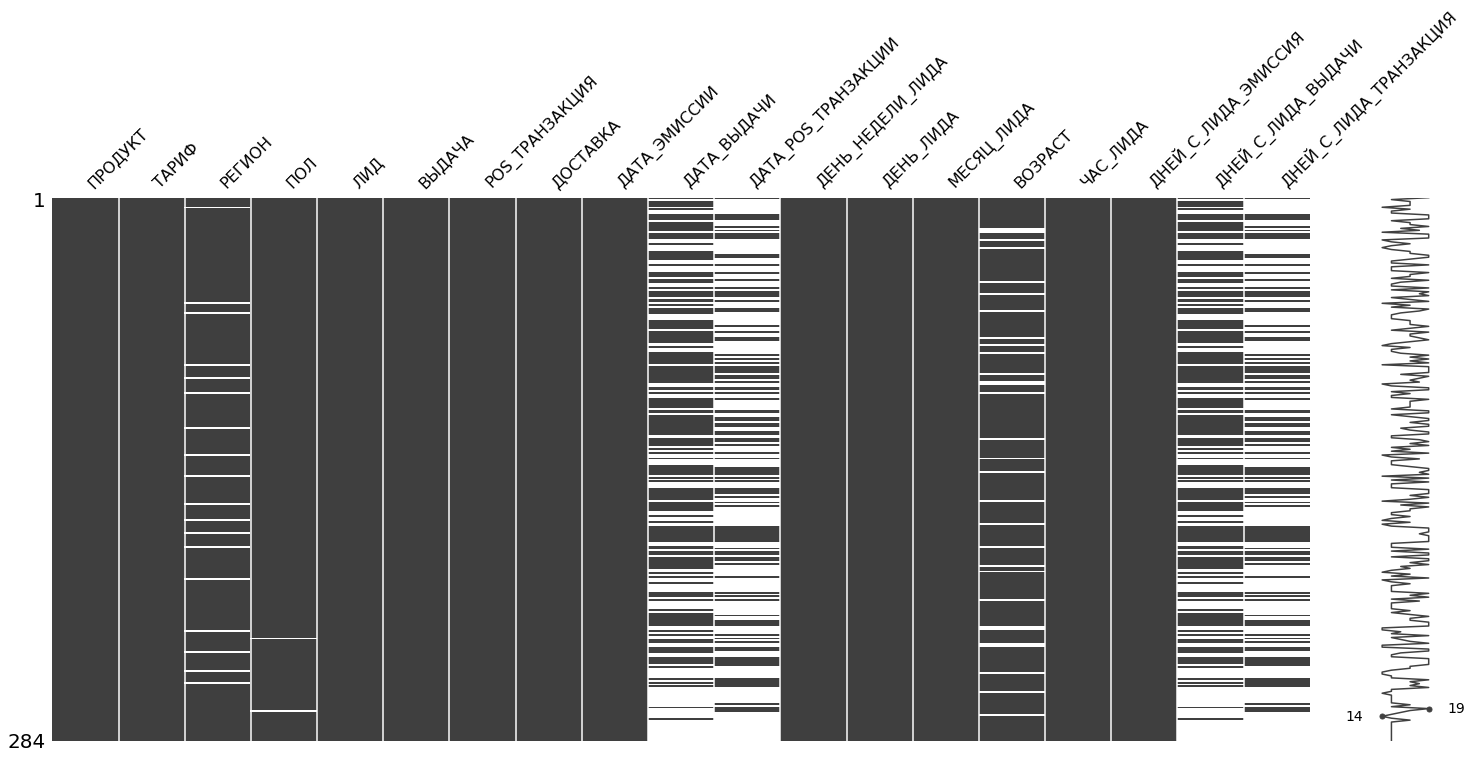

In [20]:
import missingno as msno
msno.matrix(data)

Let us compute and visualize correlation coefficient between columns

<AxesSubplot:>

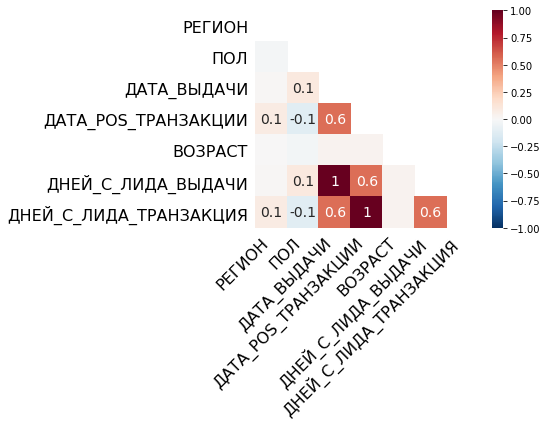

In [21]:
msno.heatmap(data, cmap='RdBu_r', figsize=(5, 4))

<AxesSubplot:>

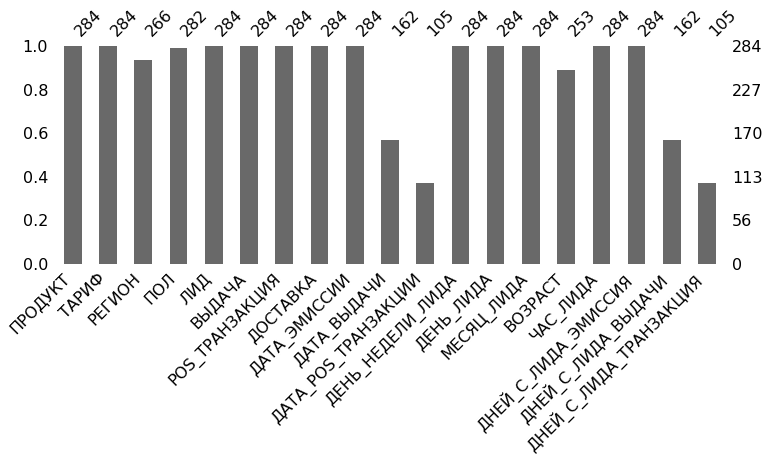

In [22]:
msno.bar(data, figsize=(12, 4))

Based on the following plots we will get insights on features correlation 

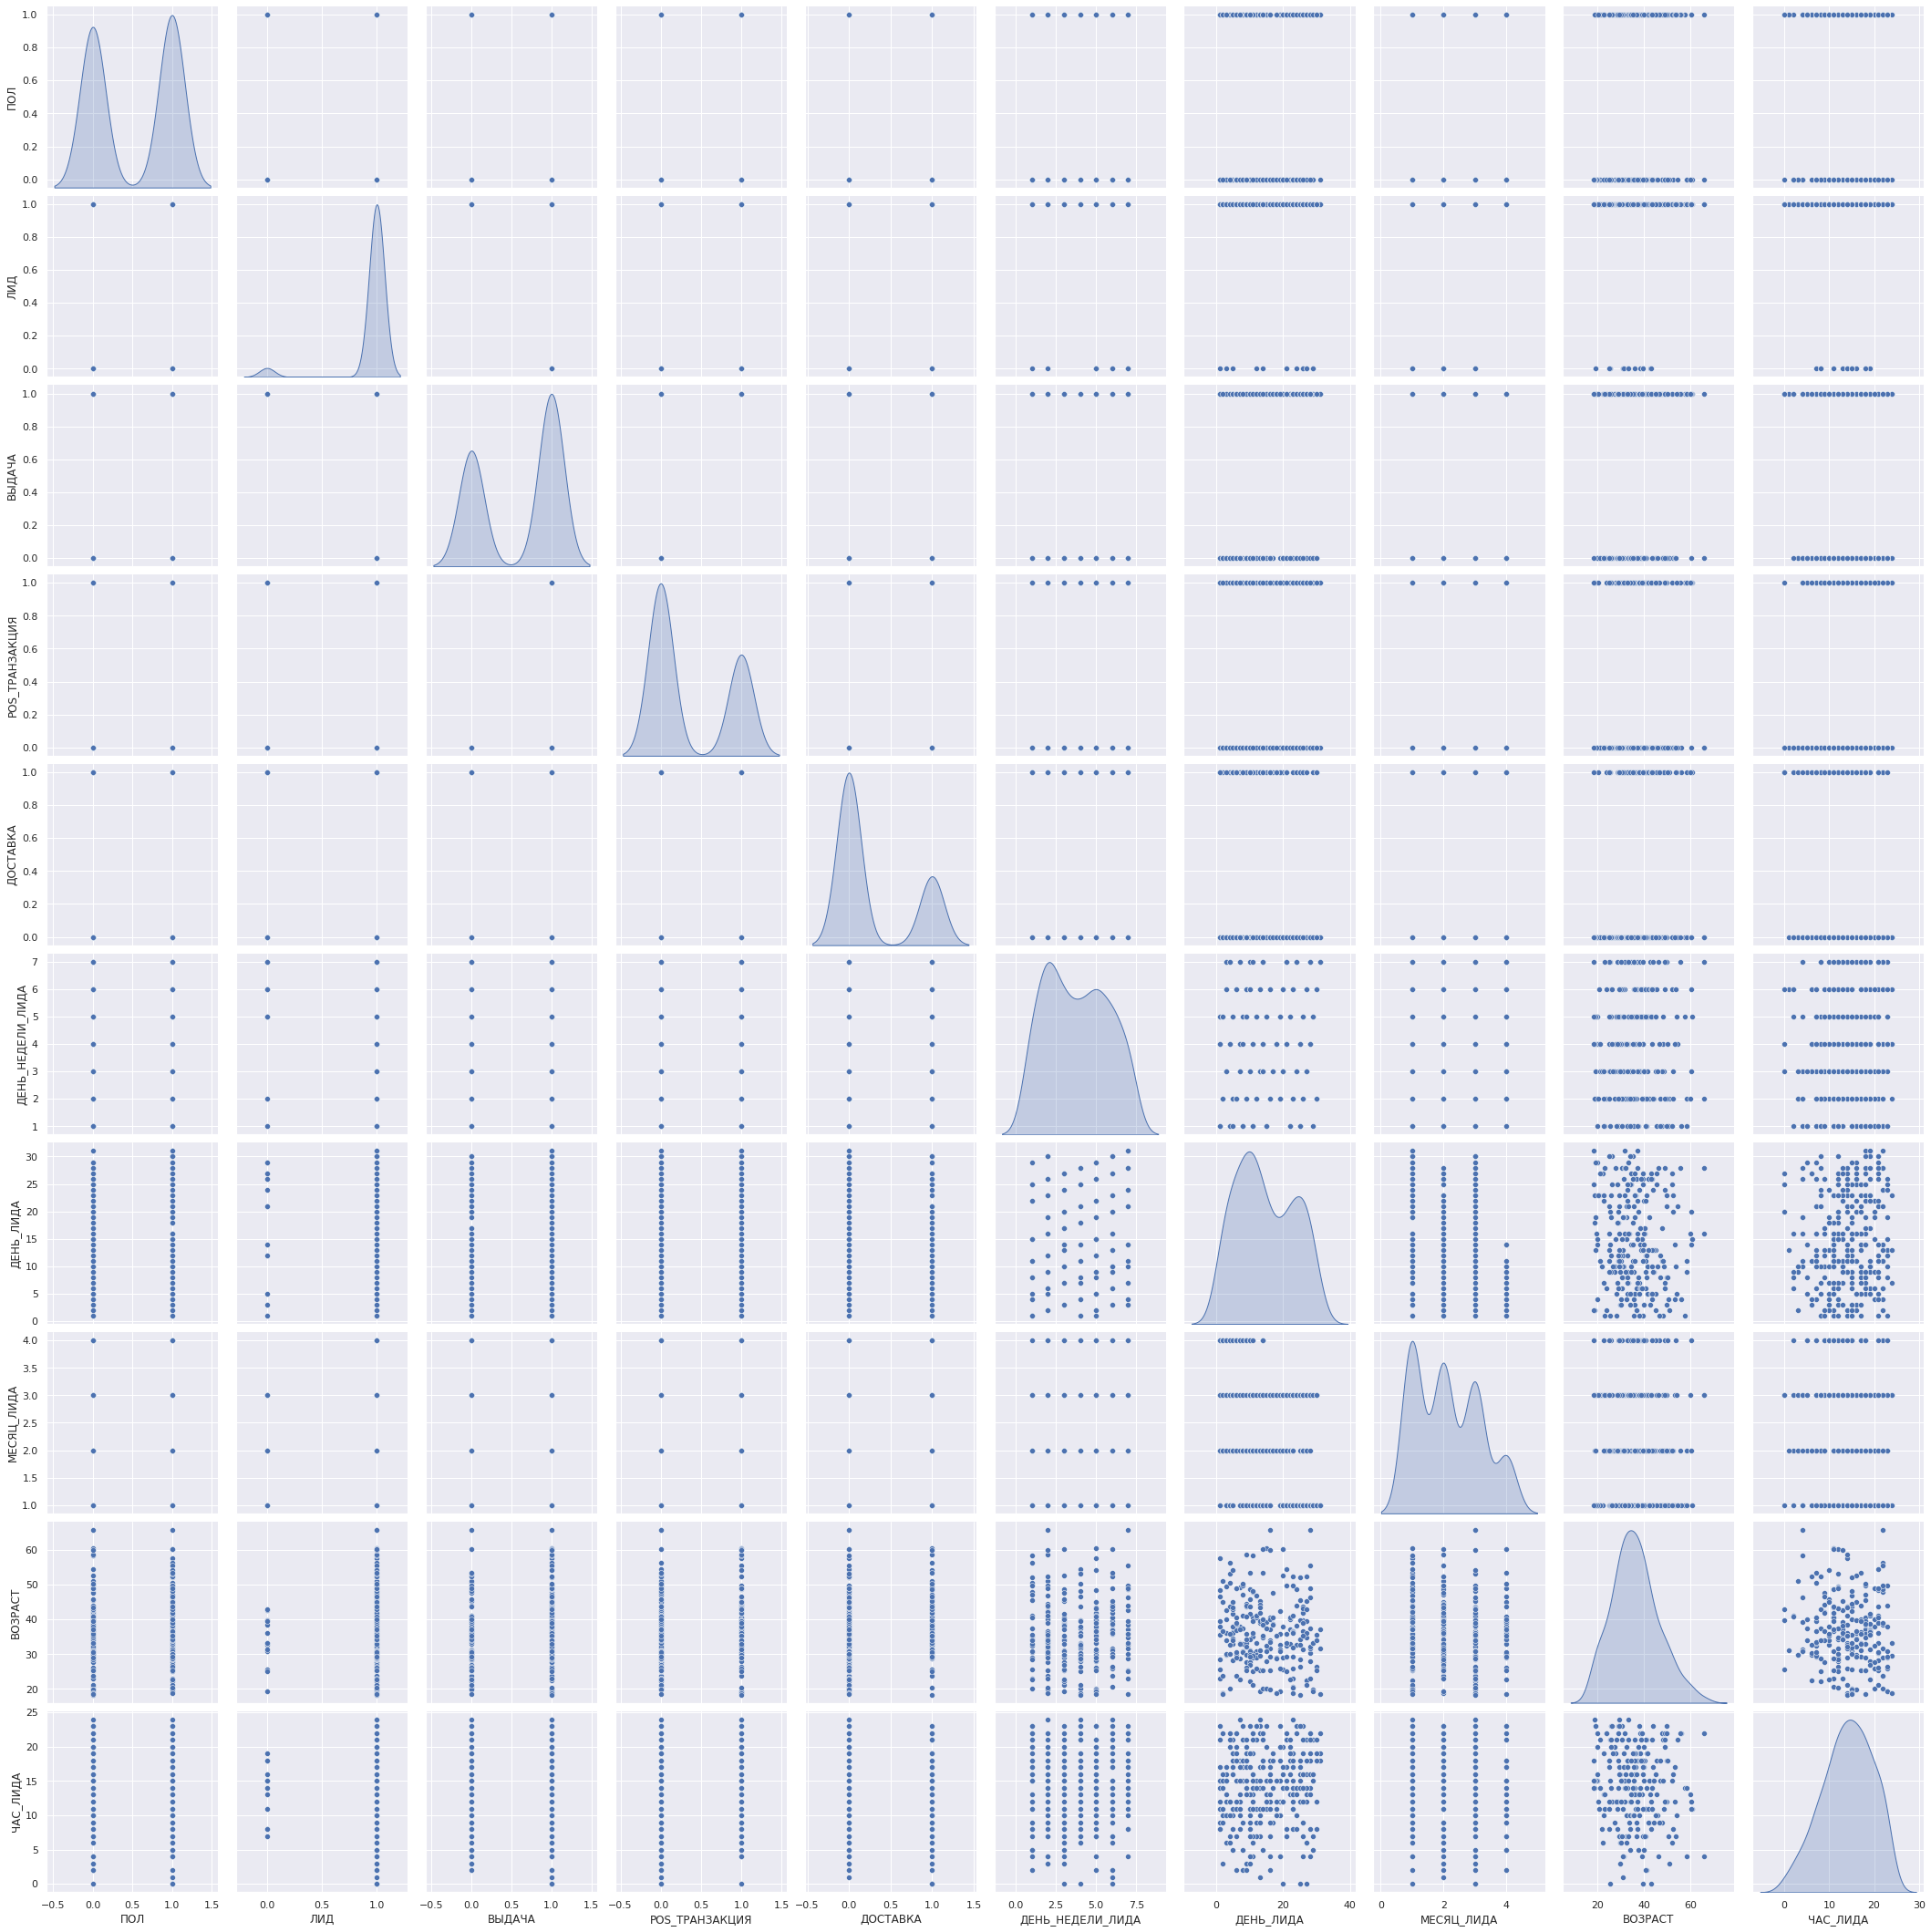

In [23]:
sns.set()
sns.pairplot(data, height=3 ,kind ='scatter',diag_kind='kde')
plt.show()

In [24]:
# drop unnecessary columns
columns = ['ДАТА_POS_ТРАНЗАКЦИИ', 'ДАТА_ВЫДАЧИ', 'ДАТА_ЭМИССИИ']
data.drop(columns=columns, inplace=True)

In [25]:
# get bigger picture
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284 entries, 3 to 464
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   ПРОДУКТ                 284 non-null    object         
 1   ТАРИФ                   284 non-null    object         
 2   РЕГИОН                  266 non-null    object         
 3   ПОЛ                     282 non-null    float64        
 4   ЛИД                     284 non-null    float64        
 5   ВЫДАЧА                  284 non-null    float64        
 6   POS_ТРАНЗАКЦИЯ          284 non-null    float64        
 7   ДОСТАВКА                284 non-null    float64        
 8   ДЕНЬ_НЕДЕЛИ_ЛИДА        284 non-null    int64          
 9   ДЕНЬ_ЛИДА               284 non-null    int64          
 10  МЕСЯЦ_ЛИДА              284 non-null    int64          
 11  ВОЗРАСТ                 253 non-null    float64        
 12  ЧАС_ЛИДА                284 non-null

In [26]:
# categorical features can be encoded with label encoder
le_region = LabelEncoder()
data['РЕГИОН'] = le_region.fit_transform(data['РЕГИОН'])

le_tariff = LabelEncoder()
data['ТАРИФ'] = le_tariff.fit_transform(data['ТАРИФ'])

le_product = LabelEncoder()
data['ПРОДУКТ'] = le_product.fit_transform(data['ПРОДУКТ'])

# cat_feat = ['РЕГИОН', 'ТАРИФ', 'ПРОДУКТ']

# for feat in cat_feat:
#     le = LabelEncoder()
#     data[feat] = le.fit_transform(data[feat])

In [27]:
data.isna().sum()

ПРОДУКТ                     0
ТАРИФ                       0
РЕГИОН                      0
ПОЛ                         2
ЛИД                         0
ВЫДАЧА                      0
POS_ТРАНЗАКЦИЯ              0
ДОСТАВКА                    0
ДЕНЬ_НЕДЕЛИ_ЛИДА            0
ДЕНЬ_ЛИДА                   0
МЕСЯЦ_ЛИДА                  0
ВОЗРАСТ                    31
ЧАС_ЛИДА                    0
ДНЕЙ_С_ЛИДА_ЭМИССИЯ         0
ДНЕЙ_С_ЛИДА_ВЫДАЧИ        122
ДНЕЙ_С_ЛИДА_ТРАНЗАКЦИЯ    179
dtype: int64

In [28]:
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
data.loc[:, 'ПОЛ'] = imp.fit_transform(data.loc[:, 'ПОЛ'].to_numpy().reshape(-1, 1))

In [29]:
columns = ['ДНЕЙ_С_ЛИДА_ВЫДАЧИ', 'ДНЕЙ_С_ЛИДА_ТРАНЗАКЦИЯ', 'ДНЕЙ_С_ЛИДА_ЭМИССИЯ']
for column in columns:
    data[column] = data[column].apply(lambda x: x.days if x is not np.nan else np.nan)

In [30]:
columns = ['ДНЕЙ_С_ЛИДА_ТРАНЗАКЦИЯ', 'ДНЕЙ_С_ЛИДА_ВЫДАЧИ', 'ДНЕЙ_С_ЛИДА_ЭМИССИЯ', 'ВОЗРАСТ']
for column in columns:
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    data.loc[:, column] = imp.fit_transform(data.loc[:, column].to_numpy().reshape(-1, 1))
    data[column] = data[column].apply(lambda days: round(days))

In [31]:
data.head()

,ПРОДУКТ,ТАРИФ,РЕГИОН,ПОЛ,ЛИД,ВЫДАЧА,POS_ТРАНЗАКЦИЯ,ДОСТАВКА,ДЕНЬ_НЕДЕЛИ_ЛИДА,ДЕНЬ_ЛИДА,МЕСЯЦ_ЛИДА,ВОЗРАСТ,ЧАС_ЛИДА,ДНЕЙ_С_ЛИДА_ЭМИССИЯ,ДНЕЙ_С_ЛИДА_ВЫДАЧИ,ДНЕЙ_С_ЛИДА_ТРАНЗАКЦИЯ
3,3,0,56,1.0,1.0,1.0,1.0,0.0,5,1,1,58,14,0,14,14
6,3,0,23,1.0,1.0,0.0,0.0,1.0,5,1,1,48,21,2,14,13
9,3,0,7,1.0,1.0,1.0,0.0,0.0,7,3,1,50,12,0,32,13
11,3,0,23,1.0,0.0,1.0,0.0,0.0,7,3,1,43,13,0,16,13
12,3,0,36,0.0,1.0,1.0,0.0,0.0,7,3,1,36,16,0,38,13


In [32]:
data.isna().sum()

ПРОДУКТ                   0
ТАРИФ                     0
РЕГИОН                    0
ПОЛ                       0
ЛИД                       0
ВЫДАЧА                    0
POS_ТРАНЗАКЦИЯ            0
ДОСТАВКА                  0
ДЕНЬ_НЕДЕЛИ_ЛИДА          0
ДЕНЬ_ЛИДА                 0
МЕСЯЦ_ЛИДА                0
ВОЗРАСТ                   0
ЧАС_ЛИДА                  0
ДНЕЙ_С_ЛИДА_ЭМИССИЯ       0
ДНЕЙ_С_ЛИДА_ВЫДАЧИ        0
ДНЕЙ_С_ЛИДА_ТРАНЗАКЦИЯ    0
dtype: int64

Статистически значимых(больше чем 0.5) показателей не присутсвует

<AxesSubplot:title={'center':'Correlation matrix of all features'}>

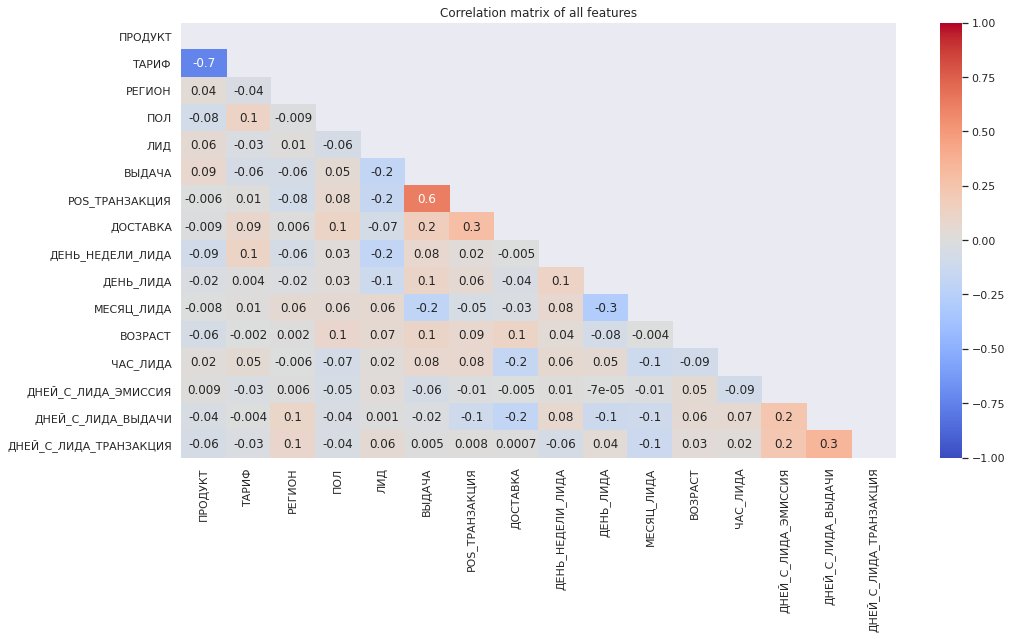

In [33]:
f, ax = plt.subplots(figsize=(16, 8))

plt.title("Correlation matrix of all features")
matrix = np.triu(data.corr())
sns.heatmap(data.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)

# Section 2

## 1. Maximize the profit

**Прибыль если**:
- выдана карта 
- есть POS транзакция

Исследуем какие группы приносят больше всего прибыли

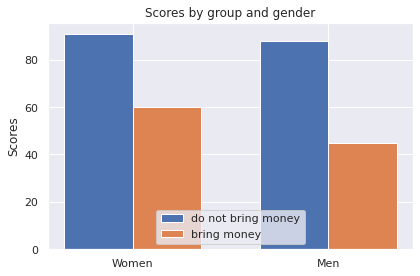

In [34]:
group1 = data[~((data['ВЫДАЧА'] == 1) & (data['POS_ТРАНЗАКЦИЯ'] == 1))]
group2 = data[(data['ВЫДАЧА'] == 1) & (data['POS_ТРАНЗАКЦИЯ'] == 1)]


fig, ax = plt.subplots()

x = np.arange(2)
width = 0.35
labels = ['Women', 'Men']
rects1 = ax.bar(x - width/2, group1['ПОЛ'].value_counts(), width, label='do not bring money')
rects2 = ax.bar(x + width/2, group2['ПОЛ'].value_counts(), width, label='bring money')

ax.set_ylabel('Scores')
ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='lower center')

fig.tight_layout()

plt.show()

In [35]:
# ['ПРОДУКТ', 'ТАРИФ']

Рассмотрим разные возрастные группы и сколько заявок принесли прибыль с каждой группы

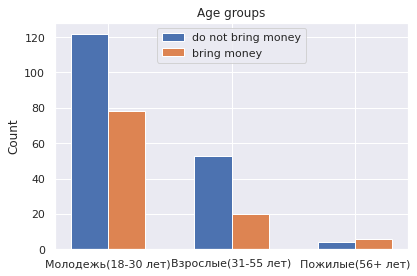

In [36]:
bins = [18, 30, 55, 100]
labels = ['Молодежь(18-30 лет)', 'Взрослые(31-55 лет)', 'Пожилые(56+ лет)']

group1 = data[~((data['ВЫДАЧА'] == 1) & (data['POS_ТРАНЗАКЦИЯ'] == 1))]
group2 = data[(data['ВЫДАЧА'] == 1) & (data['POS_ТРАНЗАКЦИЯ'] == 1)]


age_group1 = pd.cut(x=group1['ВОЗРАСТ'], bins=bins, labels=labels)
age_group2 = pd.cut(x=group2['ВОЗРАСТ'], bins=bins, labels=labels)

fig, ax = plt.subplots()
x = np.arange(len(labels))
width = 0.30

rects1 = ax.bar(x - width/2, age_group1.value_counts(), width, label='do not bring money')
rects2 = ax.bar(x + width/2, age_group2.value_counts(), width, label='bring money')

ax.set_ylabel('Count')
ax.set_title('Age groups')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc='upper center')

fig.tight_layout()

plt.show()

Исследуем какие регионы приносят больше прибыли

Больше всего прибыли приносит Алтайский регион и Москва

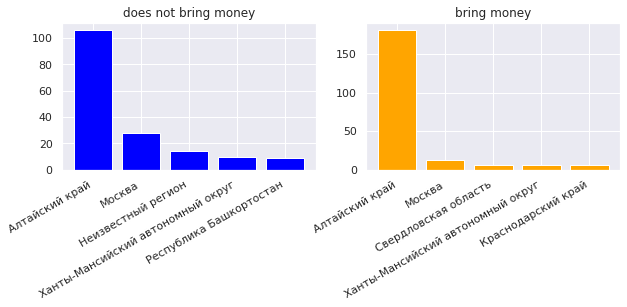

In [37]:
group1 = data[~((data['ВЫДАЧА'] == 1) & (data['POS_ТРАНЗАКЦИЯ'] == 1))]
group2 = data[(data['ВЫДАЧА'] == 1) & (data['POS_ТРАНЗАКЦИЯ'] == 1)]

region_group1 = pd.DataFrame(data=group1['РЕГИОН'], index=data.index)
region_group2 = pd.DataFrame(data=group2['РЕГИОН'], index=data.index)

region_group1 = region_group1.fillna(0)
region_group2 = region_group2.fillna(0)

top5_group1 = region_group1.value_counts()[:5]
top5_group2 = region_group2.value_counts()[:5]

get_class = lambda i: le_region.classes_[int(i[0])]
normalize_class = lambda i: "Неизвестный регион" if get_class(i) is np.nan else get_class(i)
labels1 = [normalize_class(i) for i in top5_group1.index]
labels2 = [normalize_class(i) for i in top5_group2.index]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.bar(labels1, top5_group1, color='blue')
ax1.set_title('does not bring money')

ax2.bar(labels2, top5_group2, color='orange') 
ax2.set_title('bring money')

fig.autofmt_xdate()
plt.show()

<!-- 2. узнать больше про пользователей
    - в какие дни люди больше всего покупают?
    - в какое время суток люди больше всего покупают?
    - какой регион приносит больше всего прибыли?
    - какой картой пользуются пользователи которые приносят больше прибыли?
    - кто тратит больше/чаще мужчины или женщины?
    - какая возрастная группа у пользователей, кто из них приносит больше прибыли? -->

3. какая воронка из заявки в выдачу карты

- клиент просматривает вебсайт и узнает о продукте
- клиент выбирает продукт и тариф
- клиент оставляет заявку на получение карты
- клиент получает карту

In [38]:
# how many people did not receive the card
data[(data['ВЫДАЧА'] == 0)].shape

(114, 16)

In [39]:
# how many people did receive the card but did not made the transaction yet
data[(data['POS_ТРАНЗАКЦИЯ'] == 0) & (data['ВЫДАЧА'] == 1)].shape

(65, 16)

In [40]:
# how many people did receive the card and made a transaction
data[(data['POS_ТРАНЗАКЦИЯ'] == 1) & (data['ВЫДАЧА'] == 1)].shape

(105, 16)

4. есть ли корреляция между возрастом/регионом/полом в выдачу карты

Особой корреляции между этими признаками не присутсвует

<AxesSubplot:title={'center':'Correlation matrix of some features'}>

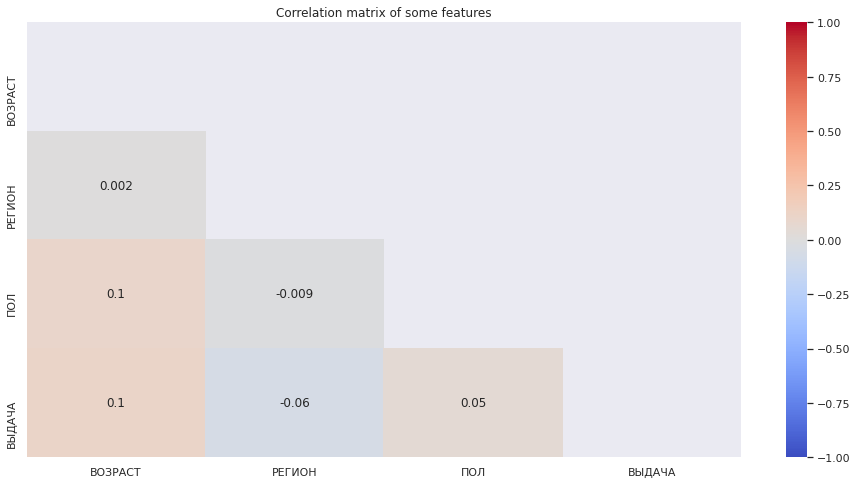

In [41]:
data_copy = data.loc[:, ['ВОЗРАСТ', 'РЕГИОН', 'ПОЛ', 'ВЫДАЧА']].copy()

f, ax = plt.subplots(figsize=(16, 8))

plt.title("Correlation matrix of some features")
matrix = np.triu(data_copy.corr())
sns.heatmap(data_copy.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)